In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from phik import phik_matrix
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

### Загрузим подготовленные данные из ноутбука data.ipynb

In [67]:
df = pd.read_csv('prepared_data.csv')
df

,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking,FCVC,CAEC,CH2O,FAF,TUE,CALC,Age,NCP,NObeyesdad
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0,1,0,21.000000,3.0,Normal_Weight
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2,1,2,3,0,1,21.000000,3.0,Normal_Weight
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,2,1,2,23.000000,3.0,Normal_Weight
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,1,1,2,0,2,27.000000,3.0,Overweight_Level_I
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,0,0,1,22.000000,1.0,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,1,2,1,1,20.976842,3.0,Obesity_Type_III
2107,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,1,1,1,1,21.982942,3.0,Obesity_Type_III
2108,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,1,1,1,1,22.524036,3.0,Obesity_Type_III
2109,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2,1,2,1,1,1,24.361936,3.0,Obesity_Type_III


In [68]:
x = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, stratify=y)

### Строим базовую модель SVM со стратификацией

In [69]:
def make_model(pipeline, x, y):
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_pred_cv_full = cross_val_predict(estimator=pipeline, 
                                   X=x, 
                                   y=y, 
                                   cv=stratified_kfold, 
                                   n_jobs=-1)

    print("Classification Report - Full Model CV:")
    print(classification_report(y_train, y_pred_cv_full, target_names=y.unique()))

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_train, y_pred_cv_full), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Full Model CV')
    plt.show()

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Overweight_Level_II       0.64      0.72      0.68       204
 Overweight_Level_I       0.51      0.42      0.46       215
Insufficient_Weight       0.50      0.68      0.58       263
     Obesity_Type_I       0.67      0.87      0.76       223
    Obesity_Type_II       0.96      1.00      0.98       243
      Normal_Weight       0.61      0.48      0.54       217
   Obesity_Type_III       0.51      0.26      0.34       218

           accuracy                           0.64      1583
          macro avg       0.63      0.63      0.62      1583
       weighted avg       0.63      0.64      0.62      1583



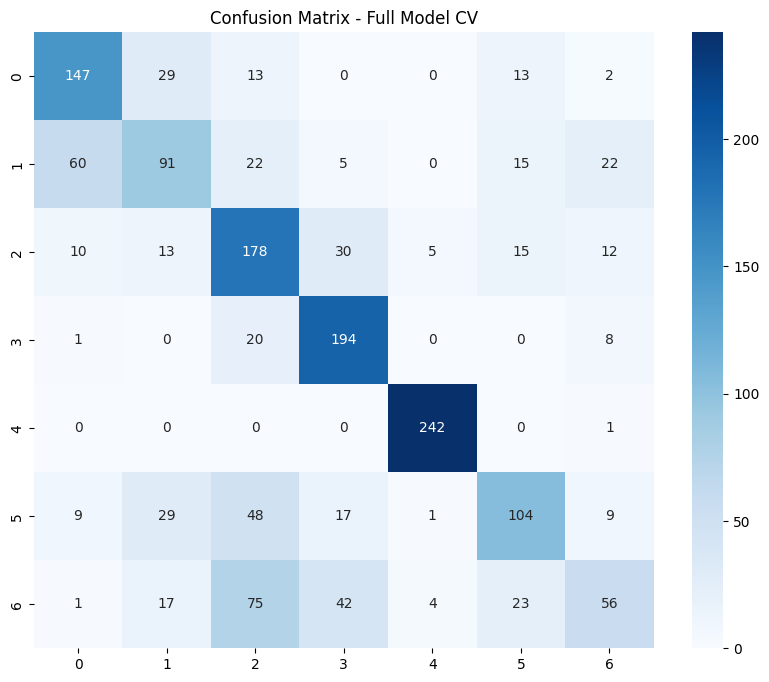

In [70]:
pipeline = make_pipeline(
        StandardScaler(),
        SVC(kernel='linear', random_state=42)
    )
make_model(pipeline, X_train, y_train)

### Использование масштабирования параметров сильно повышает точность предсказания модели! Попробуем использовать ядро RBF для модели SVM, а также введем параметр регуляризации и коэффициент для ядра

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Overweight_Level_II       0.78      0.80      0.79       204
 Overweight_Level_I       0.61      0.61      0.61       215
Insufficient_Weight       0.66      0.70      0.68       263
     Obesity_Type_I       0.73      0.97      0.83       223
    Obesity_Type_II       0.96      0.99      0.98       243
      Normal_Weight       0.69      0.55      0.61       217
   Obesity_Type_III       0.67      0.50      0.57       218

           accuracy                           0.74      1583
          macro avg       0.73      0.73      0.73      1583
       weighted avg       0.73      0.74      0.73      1583



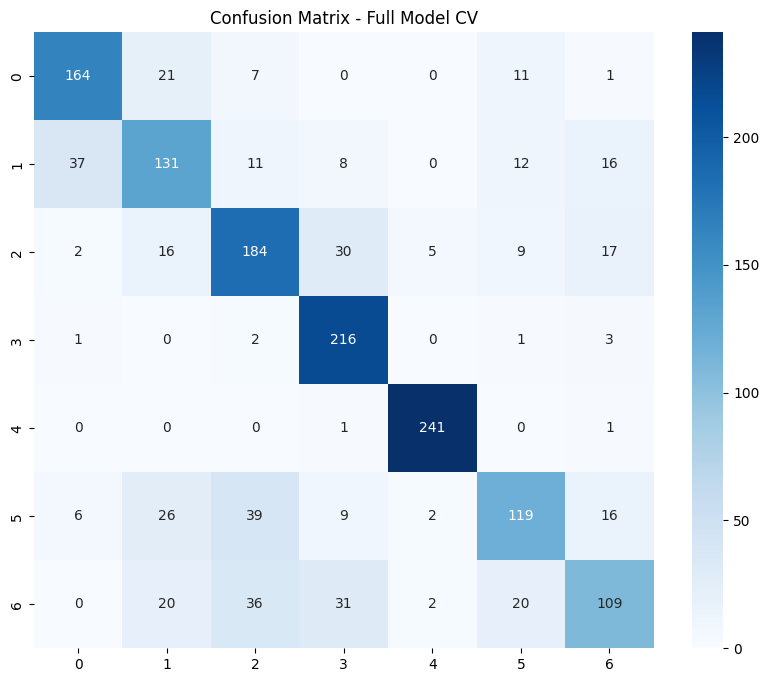

In [71]:
pipeline = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    )
make_model(pipeline, X_train, y_train)

### Видим, что для таких параметров модель хуже работает, чем для линейного ядра. Попробуем запустить модель с полиномильным ядром и сигмоидным, и дальше используем поиск гиперпараметров

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Overweight_Level_II       0.74      0.85      0.79       204
 Overweight_Level_I       0.63      0.49      0.55       215
Insufficient_Weight       0.69      0.74      0.71       263
     Obesity_Type_I       0.77      0.94      0.85       223
    Obesity_Type_II       0.96      1.00      0.98       243
      Normal_Weight       0.70      0.61      0.65       217
   Obesity_Type_III       0.64      0.54      0.59       218

           accuracy                           0.74      1583
          macro avg       0.73      0.74      0.73      1583
       weighted avg       0.74      0.74      0.74      1583



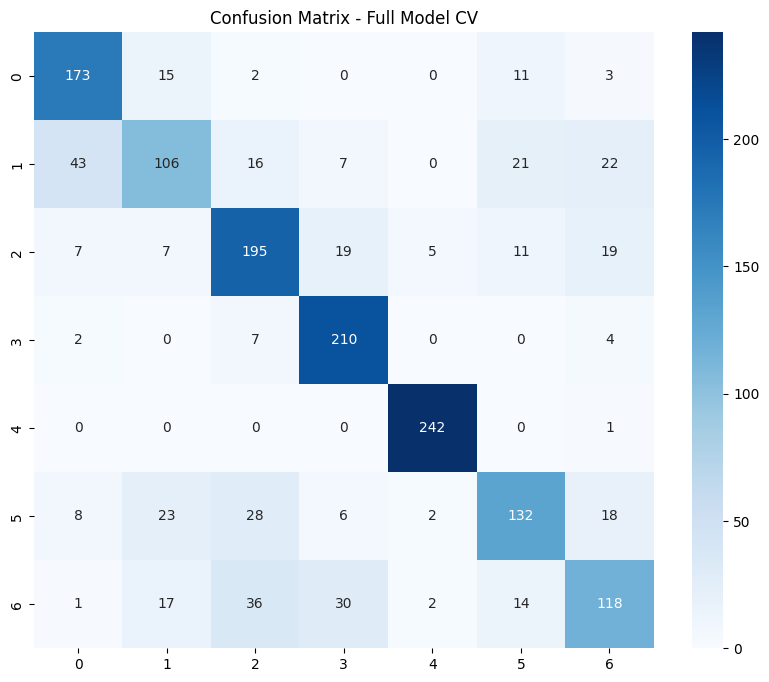

In [72]:
pipeline = make_pipeline(
        StandardScaler(),
        SVC(kernel='poly', degree=3, gamma='scale', coef0=1.0, random_state=42)
    )
make_model(pipeline, X_train, y_train)

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Overweight_Level_II       0.45      0.47      0.46       204
 Overweight_Level_I       0.34      0.33      0.34       215
Insufficient_Weight       0.41      0.52      0.46       263
     Obesity_Type_I       0.50      0.75      0.60       223
    Obesity_Type_II       0.95      0.99      0.97       243
      Normal_Weight       0.37      0.20      0.26       217
   Obesity_Type_III       0.31      0.17      0.21       218

           accuracy                           0.50      1583
          macro avg       0.48      0.49      0.47      1583
       weighted avg       0.48      0.50      0.48      1583



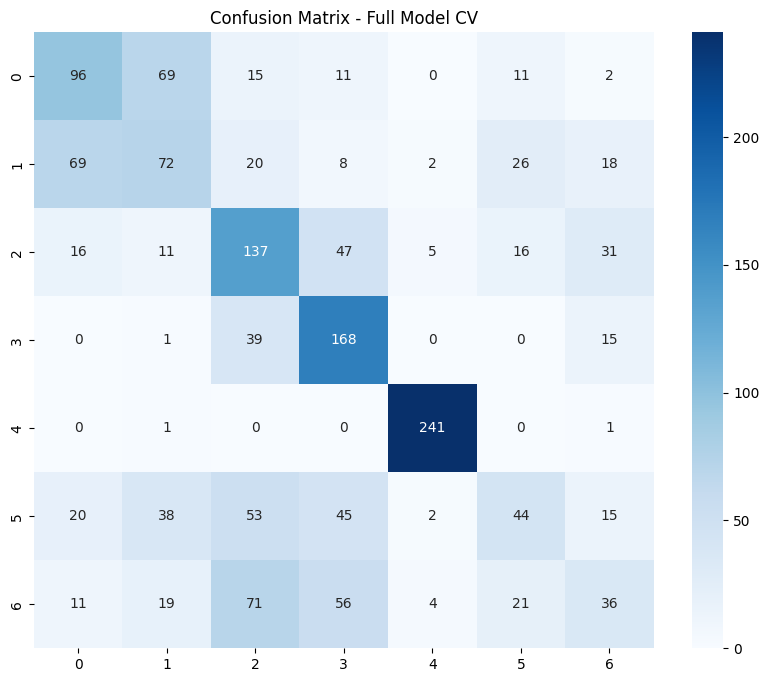

In [73]:
pipeline = make_pipeline(
        StandardScaler(),
        SVC(kernel='sigmoid', gamma='scale', coef0=0.0, C=1.0, random_state=42)
    )
make_model(pipeline, X_train, y_train)

In [74]:
pipeline = make_pipeline(
        StandardScaler(),
        SVC(random_state=42)
    )

param_grid = [
    {
        'svc__kernel': ['linear'],
        'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'svc__class_weight': [None, 'balanced']
    },
    {
        'svc__kernel': ['rbf'],
        'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
        'svc__class_weight': [None, 'balanced']
    },
    {
        'svc__kernel': ['poly'],
        'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'svc__degree': [2, 3, 4, 5],
        'svc__gamma': ['scale', 'auto', 0.1, 1],
        'svc__coef0': [0.0, 0.5, 1.0, 2.0],
        'svc__class_weight': [None, 'balanced']
    },
    {
        'svc__kernel': ['sigmoid'],
        'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'svc__gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'svc__coef0': [0.0, 0.1, 0.5, 1.0]
    }
]

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность:", grid_search.best_score_)

KeyboardInterrupt: 

Classification Report - Full Model CV:
                     precision    recall  f1-score   support

Overweight_Level_II       0.96      0.99      0.98       204
 Overweight_Level_I       0.98      0.94      0.96       215
Insufficient_Weight       0.98      0.97      0.98       263
     Obesity_Type_I       0.99      0.98      0.99       223
    Obesity_Type_II       1.00      1.00      1.00       243
      Normal_Weight       0.92      0.94      0.93       217
   Obesity_Type_III       0.93      0.94      0.93       218

           accuracy                           0.97      1583
          macro avg       0.97      0.97      0.97      1583
       weighted avg       0.97      0.97      0.97      1583



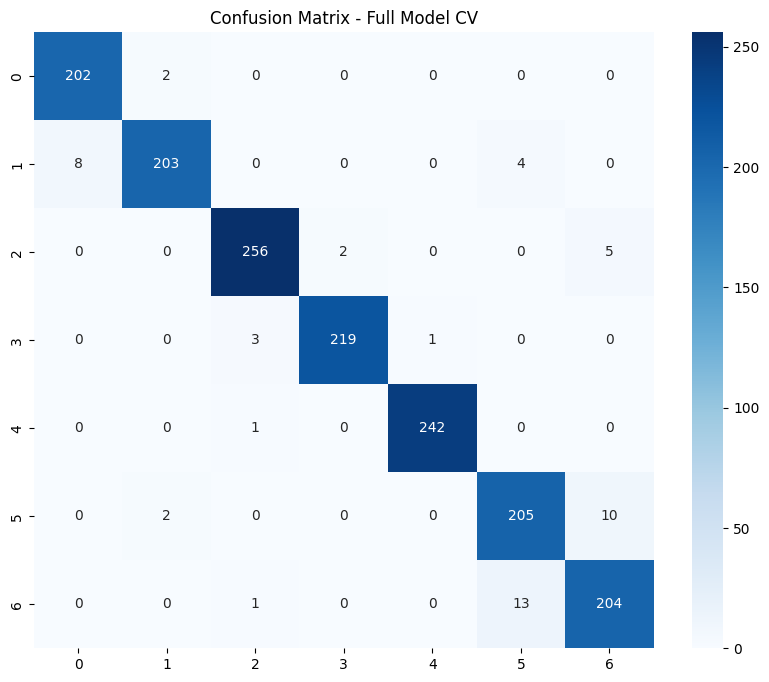

In [ ]:
pipeline = make_pipeline(
        StandardScaler(),
        SVC(kernel='linear', C=10.0, random_state=42)
    )
make_model(pipeline, X_train, y_train)

In [ ]:
#RandomizedSearchCV, 